# Квадратичный сплайн 21

### Импорт библиотек

In [1]:
import sympy as sym  # библиотека символьных вычислений
import numpy as np # библиотека для работы с массивами
import math  # для операции факториала, числа pi
import matplotlib.pyplot as plt  # для построения графиков
import pandas as pd  # для построения таблицы
from IPython.display import display  # для вывода таблицы

### Инициализация символьных переменных

In [2]:
x = sym.symbols('x')  # инициализировали символьные переменные
f = sym.Function('f')(x)  # инициализировали символьную функцию
# N = 1 - номер в списке группы
f = x - sym.sin(x) - 0.25  # определили функцию соответственно номеру в списке группы
a = 0
b = 10  # [a,b] - выбранный интервал интерполирования

### Определим функцию решения СЛАУ методом отражений
#### понадобится ниже
метод Гаусса неустойчив на плохо обусловленных матрицах (например, при n=3 число обусловленности 1.5тыс.)
метод Гаусса с выбором максимального элемента тоже не помог
Метод отражений справляется лучше на плохо обусловленных матрицах, но и он показал неудовлетворительные результаты

In [3]:
def metod_otr(A, b):
    n = len(b)
    Q = np.eye(n)
    R = np.copy(A)
    for i in range(n-1):
        # строим w
        y = np.zeros(n-i)  # n-i-й столбец матрицы R
        for j in range(i, n):
            y[j-i]=R[j][i]
        #print('y= ', y)
        z = np.zeros(n-i)
        z[0] = 1  # z - орт е1
        #print('z=', z)
        alpha = np.linalg.norm(y)
        #print('a*z=', alpha*z)
        w = (y-alpha*z)/np.linalg.norm(y-alpha*z)
        #print('w=', w)
        #print('w norm =', np.linalg.norm(w))
        
        # строим Q, R
        W = np.eye(n-i)  # W= w*wT - матрица
        for j in range(n-i):
            for k in range(n-i):
                W[j][k] = w[j]*w[k]
        #print('W=', W)
        Q_small = np.eye(n-i)-2*W
        R_small = np.zeros((n-i, n-i))
        for j in range(i, n):
            for k in range(i, n):
                R_small[j-i][k-i] = R[j][k]
        #print('Q_small=', Q_small)
        #print('R_small=', R_small)     
        R_small = np.dot(Q_small,R_small)
        #print('R_small=', R_small)
        # Q new, размера nxn
        Q_new = np.eye(n)
        if (i==0):
            R = np.eye(n)
        for j in range(i, n):
            for k in range(i, n):
                Q_new[j][k] = Q_small[j-i][k-i]
                R[j][k] = R_small[j-i][k-i]           
        #print('Q_new=', Q_new)
        #print('R=', R)
        Q = np.dot(Q, Q_new)
        #print('Q=', Q)
        #print('QR=', np.dot(Q,R))
        #print()
    # обратный ход
    y = np.dot(np.transpose(Q),b)
    x = np.copy(y)
    for i in range(n-1, -1, -1):
        for j in range(n-2, i-1, -1):
            x[i] -= x[j+1]*R[i][j+1]
        x[i]/=R[i][i]
    return x

# Сплайн S_21
## На равноотстоящих узлах

функция возвращает вектор a=(a_11,a_10,a_21,a_20,...,a_n-1.1,a_n0)

In [4]:
def S_21(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi) 
    A = []  
    y = []
    
    # строим матрицу А, вектор у
    for i in range(n-1):
        row1 = np.zeros(3*n-3)  # 1-я, 4-я и т.д. строка матрицы А
        row1[3*i] = knots[i]**2  # 1-й, 4-й и т.д. элемент строки
        row1[3*i+1] = knots[i]  # 2-й элемент
        row1[3*i+2] = 1  # 3-й
        A.append(row1)  # присоединили строку к матрице А
        
        row2 = np.zeros(3*n-3)
        row2[3*i] = knots[i+1]**2
        row2[3*i+1] = knots[i+1]
        row2[3*i+2] = 1 
        A.append(row2)
        
        y.append(f.subs(x, knots[i]))
        y.append(f.subs(x, knots[i+1]))
        
        row3 = np.zeros(3*n-3)
        row3[3*i] = 2*knots[i+1]
        row3[3*i+1] = 1
        # если i=n-2, то в 3-й строке не 6 элементов, а 3
        if (i!=n-2):
            row3[3*i+3] = -2*knots[i+1]
            row3[3*i+4] = -1
        y.append(0)
        A.append(row3)
    # решим СЛАУ с помощью метода отражений
    ans = metod_otr(np.array(A), np.array(y))
    return ans

## Функция поиска максимума отклонения
### на равноостоящих узлах

In [5]:
def RS(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi) 
    ans = S_21(n, f)  # сплайн 2,1, вектор коэффициентов
    m = 10*n  # количество точек разбиения
    r = []  # массив максимумов отклонений сплайна на отрезках [x_j,x_j+1]
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[3*j]*x**2 + ans[3*j+1]*x+ans[3*j+2]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        r.append(max(rj))  # присоединили максимальный на отрезке
    return max(r)

## Сплайн на оптимальных узлах

всё то же самое, изменены только узлы интерполирования

In [6]:
def S_21opt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()  # отсортировала 
    A = [] 
    y = []
    
    # строим матрицу А, вектор у
    for i in range(n-1):
        row1 = np.zeros(3*n-3)
        row1[3*i] = knots[i]**2
        row1[3*i+1] = knots[i]
        row1[3*i+2] = 1
        A.append(row1)
        row2 = np.zeros(3*n-3)
        row2[3*i] = knots[i+1]**2
        row2[3*i+1] = knots[i+1]
        row2[3*i+2] = 1 
        A.append(row2)
        y.append(f.subs(x, knots[i]))
        y.append(f.subs(x, knots[i+1]))
        row3 = np.zeros(3*n-3)
        row3[3*i] = 2*knots[i+1]
        row3[3*i+1] = 1
        if (i!=n-2):
            row3[3*i+3] = -2*knots[i+1]
            row3[3*i+4] = -1
        y.append(0)
        A.append(row3)
    # решим СЛАУ с помощью метода отражений
    ans = metod_otr(np.array(A), np.array(y))
    return ans

### Функция поиска максимума отклонения на оптимальных узлах

In [7]:
def RSopt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    ans = S_21opt(n, f) 
    m = 10*n
    r = []  # массив отклонений ИПЛ в точках T
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[3*j]*x**2 + ans[3*j+1]*x+ans[3*j+2]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        r.append(max(rj))  # присоединили максимальный на отрезке
    return max(r)

# Построение таблицы

In [8]:
df = pd.DataFrame({'n': [], 'm':[], 'RS21n': [], 'RS21optn':[]})  # для построения таблицы поведения S21 при увеличении количества узлов интерполирования
n_knots = [4, 6, 9, 20, 30, 50]
for n in n_knots:
    RS21= RS(n, f)  # максимум отклонения на равноостоящих узлах
    RS21opt = RSopt(n,f)  # максимум отклонения на оптимальных узлах
    line = {'n': n, 'm': 10*n, 'RS21n':RS21, 'RS21optn':RS21opt}
    df = df.append(line, ignore_index=True)
display(df)

,n,m,RS21n,RS21optn
0,4.0,40.0,2.71289168790295,2.91724137448813
1,6.0,60.0,1.34130152652727,0.881726079593689
2,9.0,90.0,0.636457978160759,0.799091481145185
3,20.0,200.0,0.245198122169641,0.346575572472596
4,30.0,300.0,0.159373072460290,0.233454806784947
5,50.0,500.0,0.0939926127157833,0.141681249438993


# Построение графиков
## на равноотстоящих узлах

In [9]:
# для удобства определим функцию построения графика
def plot_spline(n, a, b, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi) 
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_21(n,f)
        qi = ans[3*i]*x**2 + ans[3*i+1]*x+ans[3*i+2]  # q_i = a_i2*x^2+a_i1*x+a_i0
        lix = [qi.subs(x, xk) for xk in X]
        plt.plot(X, lix, '--', linewidth = 3)

Text(0.5, 1.0, 'График №1 S_21 n=3, n=10, n=50')

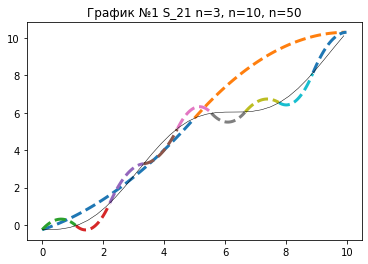

In [10]:
plt.figure()
x = sym.symbols('x')
li = sym.Function('li')(x)
ab = np.arange(a, b, 0.3)
fx = [f.subs(x, xi) for xi in ab]
plot_spline(3, 0, 10, f)
plot_spline(10, 0, 10, f)
#plot_spline(50, 0, 10, f)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №1 S_21 n=3, n=10, n=50')

### Для наглядности так же в таком варианте 

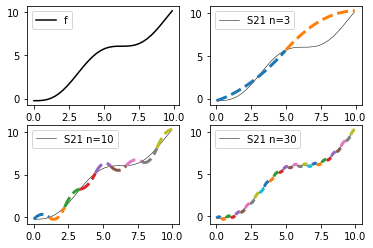

In [11]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
plt.legend('f(x)')
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(3, 0, 10, f)
label = ['S21 n=3']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(10, 0, 10, f)
label = ['S21 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(30, 0, 10, f)
label = ['S21 n=30']
plt.legend(label)

## на оптимальных узлах

In [12]:
# для удобства определим функцию построения графика
def plot_spline_opt(n, a, b, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_21opt(n,f)
        li = ans[3*i]*x**2 + ans[3*i+1]*x+ans[3*i+2]  # q_i = a_i2*x^2+a_i1*x+a_i0
        lix = [li.subs(x, xk) for xk in X]
        plt.plot(X, lix, '--', linewidth = 3)

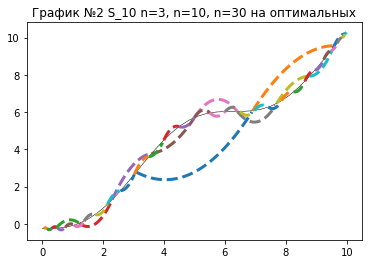

In [13]:
plt.figure(4)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №2 S_10 n=3, n=10, n=30 на оптимальных')
plot_spline_opt(3, 0, 10, f)
plot_spline_opt(10, 0, 10, f)
plot_spline_opt(30, 0, 10, f)

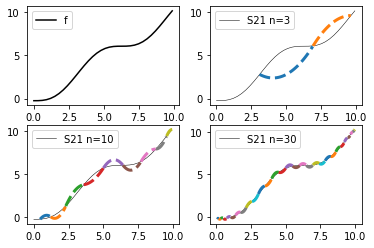

In [14]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
plt.legend('f(x)')
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(3, 0, 10, f)
label = ['S21 n=3']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(10, 0, 10, f)
label = ['S21 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(30, 0, 10, f)
label = ['S21 n=30']
plt.legend(label)